# H5N1 tree parsing 

January 10, 2019 

I decided to use the exact same protocol for parsing trees that I had used to analyze H7N9 data for Shirleen, but apply it to H5N1 across the genome. The goal is to see whether mutations that were detected within-host are enriched on branches leading to human infections. 

I used json files from nextstrain.org/flu/avian/h5n1. 

I made a few changes to the actual code: I put everything into functions, added a few functions to convert the output to dataframes, and added in loops to simultaneously run all the genes at once. 

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib, csv, json
from subprocess import call
import collections
from collections import Counter
from Bio import SeqIO
from Bio import Seq
import Bio.Phylo
import pandas as pd
import numpy as np
import rpy2
from scipy import stats
%load_ext rpy2.ipython 

In [2]:
# this is to alleviate a strange problem. When running pandas .groupby, it kept freezing the ipython kernel 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Functions for reading jsons and generating BioPhylo tree object 

These functions are copied and pasted directly from nextstrain augur/base/io_util.py

In [3]:
# function to use the json module to read in a json file and store it as "data"                
def read_json(file_name):
    try:
        handle = open(file_name, 'r')
    except IOError:
        pass
    else:
        data = json.load(handle)
        handle.close()
    return data

In [4]:
# original code that Trevor gave me for parsing through tree jsons and returning descendents
def all_descendants(node):
    """Take node, ie. dict, and return a flattened list of all nodes descending from this node"""
    yield node
    
    # this will recursively return all internal nodes (nodes with children)
    if 'children' in node:
        for child in node['children']:
            for desc in all_descendants(child):
                yield desc

In [5]:
# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

In [6]:
def annotate_parents(tree):
    # Get all parent nodes by node.
    parents_by_node = all_parents(tree)

    # Next, annotate each node with its parent.
    for node in tree.find_clades():
        if node == tree.root:
            node.up = None
        else:
            node.up = parents_by_node[node]

    # Return the tree.
    return tree

In [7]:
def json_to_tree(json_dict, root=True):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.

    Assigns links back to parent nodes for the root of the tree.

    >>> import json
    >>> json_fh = open("tests/data/json_tree_to_nexus/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child, root=False) for child in json_dict["children"]]

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    node.numdate = node.attr.get("num_date")
    node.branch_length = node.attr.get("div")

    if "translations" in node.attr:
        node.translations = node.attr["translations"]

    if root:
        node = annotate_parents(node)

    return node

## Parse H5N1 trees

This code will loop through each clade in the tree (starting from the root out to the terminal nodes). For each clade, gather all terminal nodes that fall within that clade. If the current clade includes only human sequences, then it will be labelled human to human or bird to human as follows: 

**1. Human to human:** If the current clade includes only human sequences, look at its parent node. If all terminal branches stemming from its parent node are human, then the current clade falls within a monophyletic human clade. This branch is labelled "human to human." SNPs on this branch are added to the "human_to_human" list. 


**2. Bird to human:** If the current clade includes only human sequences, look at its parent node. If the terminal branches stemming from its parent node include both human and nonhuman sequences, then the current clade represents the branch leading to a monophyletic human clade. This branch is labelled "bird to human." SNPs on this branch are added to the "bird_to_human" list. 

If the current clade includes a mixture of human and nonhuman sequences, the branch leading to that clade is labelled as "bird to bird". Any SNPs that occur along this branch are added to the "bird_to_bird" list. 

**Tree tips** are treated as clades themselves, and are categorized as above. For example, a human tip that falls within a bird clade will have the branch leading to it labelled as bird to human, and those SNPs will be added to the bird_to_human list. A human tip that falls within a human-only clade will have its branch labelled as human to human, and its SNPs will be added to the human_to_human list. 

In [8]:
def parse_tree_and_return_muts(tree, gene): 

# lists to store amino acid mutations 
    bird_to_bird = []
    bird_to_human = []
    human_to_human = []

    # loop through all the nodes in the tree, going from root to tip 
    for clade in tree.find_clades(): 
        tips_list = []
        hosts_list = []

        # for each clade, output all terminal nodes that fall within that clade 
        for terminal in clade.get_terminals():
            hosts_list.append(terminal.attr['host'])
            tips_list.append(terminal.name)
        
        # if all terminal nodes are human, print the clade name and the list of terminal branches it entails
        if set(hosts_list) == {'human'}:
            #print(clade, tips_list, hosts_list)
            
            # now check to see if the node above includes terminal nodes that are not human 
            up1_hosts_list = []
            up1_tips_list = []

            # get terminal nodes for the node up one (parent node)
            for x in clade.up.get_terminals():   
                up1_hosts_list.append(x.attr['host'])
                up1_tips_list.append(x.name)

            # if the node above contains not just human samples, then clade should be set to bird_to_human
            if len(set(up1_hosts_list)) > 1 and hasattr(clade, "aa_muts") and clade.aa_muts != {}:
                #print("banana", clade.up, up1_tips_list, up1_hosts_list, set(up1_hosts_list), len(set(up1_hosts_list)))
                if gene in clade.aa_muts:
                    for mut in clade.aa_muts[gene]:
                        bird_to_human.append(mut)

            # if including the node above still gives you an entirely human clade, then add these mutations to the 
            # human to human count 
            elif set(up1_hosts_list) == {'human'} and hasattr(clade, "aa_muts") and clade.aa_muts != {}:
                #print("sloth", clade.up, up1_tips_list, up1_hosts_list,set(up1_hosts_list), len(set(up1_hosts_list)))
                if gene in clade.aa_muts:
                    for mut in clade.aa_muts[gene]:
                        human_to_human.append(mut)

            elif clade.aa_muts == {}:
                pass

            else:
                print('some other option I havent thought of but need to address')
                print(clade.up, up1_tips_list, up1_hosts_list, clade.aa_muts)

        else:
            if hasattr(clade, "aa_muts") and clade.aa_muts != {}:
                if gene in clade.aa_muts:
                    for a in clade.aa_muts[gene]: 
                        bird_to_bird.append(a)
                    
    return(bird_to_bird, bird_to_human, human_to_human)

In [9]:
# print(len(bird_to_bird), len(set(bird_to_bird)), len(bird_to_human), len(set(bird_to_human)), len(human_to_human), len(set(human_to_human)))

### Count the number of times each mutation occurs in each list 

In [10]:
aa_dict = {"A":"Ala","R":"Arg","N":"Asn","D":"Asp","C":"Cys","Q":"Gln","E":"Glu","G":"Gly","H":"His","I":"Ile","L":"Leu","K":"Lys","M":"Met","F":"Phe","P":"Pro","S":"Ser","T":"Thr","W":"Trp","Y":"Tyr","V":"Val", "*":"stop"}

In [11]:
def convert_aa_changes(bb, bh, hh):
    bb2 = []
    bh2 = []
    hh2 = []
    
    for a in bb:
        # convert aa symbols to 3-letter abbreviations
        first_aa = a[0]
        new_first = aa_dict[first_aa]
        last_aa = a[-1]
        new_last = aa_dict[last_aa]
        a = a.replace(first_aa, new_first)
        a = a.replace(last_aa, new_last)
        bb2.append(a)  
    for a in bh:
        # convert aa symbols to 3-letter abbreviations
        first_aa = a[0]
        new_first = aa_dict[first_aa]
        last_aa = a[-1]
        new_last = aa_dict[last_aa]
        a = a.replace(first_aa, new_first)
        a = a.replace(last_aa, new_last)
        bh2.append(a)
    for a in hh:
        # convert aa symbols to 3-letter abbreviations
        first_aa = a[0]
        new_first = aa_dict[first_aa]
        last_aa = a[-1]
        new_last = aa_dict[last_aa]
        a = a.replace(first_aa, new_first)
        a = a.replace(last_aa, new_last)
        hh2.append(a)
        
    return(bb2, bh2, hh2)

In [12]:
def return_SNP_counts(bb, bh, hh):
    
    # use Counter to count the number of times each amino acid change is detected in each list; print total unique SNPs
    bird_to_bird_count = Counter(bird_to_bird)
    bird_to_human_count = Counter(bird_to_human)
    human_to_human_count = Counter(human_to_human)
    #print(len(bird_to_bird_count), len(bird_to_human_count), len(human_to_human_count))
    
    # get a complete list of all of the SNPs identified
    all_SNPs = set(bird_to_human + bird_to_bird + human_to_human)
    
    # loop through and count how many times each SNP occurs in each dataset 
    all_counts = {}

    for a in all_SNPs:
                
        if a in bird_to_bird_count:
            b_to_b = bird_to_bird_count[a]
        else:
            b_to_b = 0

        if a in bird_to_human_count:
            b_to_h = bird_to_human_count[a]
        else:
            b_to_h = 0

        if a in human_to_human_count:
            h_to_h = human_to_human_count[a]   
        else:
            h_to_h = 0


        all_counts[a] = {"bird_to_bird":b_to_b, "bird_to_human": b_to_h, "human_to_human": h_to_h}
    return(all_counts)

In [13]:
def generate_dataframe(all_counts, gene, df):
    df1 = pd.DataFrame.from_dict(all_counts, orient='index')
    df1 = df1.reset_index()
    df1.columns=['coding_region_change','bird_to_bird','bird_to_human','human_to_human']
    df1['gene'] = gene
    df = df.append(df1)
    return(df)

### Loop through all gene trees and run

In [14]:
df = pd.DataFrame()

for f in glob.glob("/Users/lmoncla/src/avian-flu-h5-Cambodia/auspice/flu_avian_h5n1*_tree.json"):
    tree = read_json(f)
    tree = json_to_tree(tree)
    gene = f.split("/")[-1].split("_")[3].upper()
        
    if gene != "MP" and gene != "NS":
        # run everything
        bird_to_bird, bird_to_human, human_to_human = parse_tree_and_return_muts(tree, gene)
        bird_to_bird, bird_to_human, human_to_human = convert_aa_changes(bird_to_bird, bird_to_human, human_to_human)
        all_counts = return_SNP_counts(bird_to_bird, bird_to_human, human_to_human)
        df = generate_dataframe(all_counts, gene, df)
        
    elif gene == "MP":
        genes = ["M1","M2"]
        for g in genes: 
            bird_to_bird, bird_to_human, human_to_human = parse_tree_and_return_muts(tree, g)
            bird_to_bird, bird_to_human, human_to_human = convert_aa_changes(bird_to_bird, bird_to_human, human_to_human)
            all_counts = return_SNP_counts(bird_to_bird, bird_to_human, human_to_human)
            df = generate_dataframe(all_counts, g, df)
    
    elif gene == "NS":
        genes = ["NS1","NS2"]
        for g in genes: 
            bird_to_bird, bird_to_human, human_to_human = parse_tree_and_return_muts(tree, g)
            bird_to_bird, bird_to_human, human_to_human = convert_aa_changes(bird_to_bird, bird_to_human, human_to_human)
            all_counts = return_SNP_counts(bird_to_bird, bird_to_human, human_to_human)
            df = generate_dataframe(all_counts, g, df)

In [15]:
df['gene'] = df['gene'].fillna("NA")
df['site'] = df['gene'] + " " + df['coding_region_change']
df.head()

,coding_region_change,bird_to_bird,bird_to_human,human_to_human,gene,site
0,Ala102Asp,2,0,0,HA,HA Ala102Asp
1,Ala102Gly,1,0,0,HA,HA Ala102Gly
2,Ala102Ser,14,0,0,HA,HA Ala102Ser
3,Ala102Thr,13,0,1,HA,HA Ala102Thr
4,Ala102Val,28,1,0,HA,HA Ala102Val


In [16]:
sloth = df[df['site'] == 'PB2 Glu627Lys']
sloth

,coding_region_change,bird_to_bird,bird_to_human,human_to_human,gene,site
501,Glu627Lys,15,28,8,PB2,PB2 Glu627Lys


### Write counts out to a text file 

In [23]:
# write out counts to a file 
# counts_outfile = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/within-host-vs-global-SNP-frequencies-analysis/tree-parsing/h5n1_ha_snps_full_tree_2019-01-10.txt"

In [24]:
#with open(counts_outfile, "w") as outfile:
    
    #header = "\t".join(["amino_acid_change","count_in_human_to_human_transitions","count_in_bird_to_human_transitions","count_in_bird_to_bird_transitions"])
    #outfile.write(header + "\n")
    
#for a in all_counts: 
    #line_to_write = "\t".join([a, str(all_counts[a]["human_to_human"]), str(all_counts[a]["bird_to_human"]), str(all_counts[a]["bird_to_bird"])])
        
    #with open(counts_outfile, "a") as outfile: 
        #outfile.write(line_to_write + "\n")

## Read in within-host SNP calls

In [17]:
within_host= "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/Cambodia_H5_sequence_raw_data/combined_human_and_bird_usable_subset/combined_vcfs_nodups/combined_variants_nodups_2018-11-13.txt"
wh = pd.DataFrame.from_csv(within_host, sep="\t")
wh.head()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
sampleid,,,,,,,,,,
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [18]:
# fix NA misread as nan
wh['gene'] = wh['gene'].fillna("NA")

#subset to just nonsynonymous changes 
wh = wh.loc[wh['synonymous_nonsynonymous'] == 'nonsynonymous']
wh = wh.loc[wh['coding_region_change'] != 'Xaa240Gly']

# add in a species column
wh['originating_species'] = wh['sample'].str.contains("duck", "duck")
wh['originating_species'] = wh['originating_species'].replace(True,"duck")
wh['originating_species'] = wh['originating_species'].replace(False,"human")
wh.reset_index(inplace=True)

# subset down to just coding region change and originating species 
wh = wh[['coding_region_change','originating_species','gene']]
wh['site'] = wh['gene'] + " " + wh['coding_region_change']
wh.head()

,coding_region_change,originating_species,gene,site
0,Ala265Thr,duck,HA,HA Ala265Thr
1,Gln117Arg,duck,NP,NP Gln117Arg
2,Arg367Lys,duck,PA,PA Arg367Lys
3,Met317Val,duck,PB1,PB1 Met317Val
4,Ala199Val,duck,M1,M1 Ala199Val


## Merge within-host dataframe with tree transitions counts dataframe 

In [19]:
merged = pd.DataFrame(wh[['coding_region_change','gene','originating_species', 'site']]).merge(df, how="left", on=['site','coding_region_change','gene'])
merged = merged.drop_duplicates()
merged['gene'] = merged['gene'].fillna("NA")
merged = merged.fillna(0)
merged.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human
0,Ala265Thr,HA,duck,HA Ala265Thr,5.0,0.0,0.0
1,Gln117Arg,NP,duck,NP Gln117Arg,0.0,0.0,0.0
2,Arg367Lys,PA,duck,PA Arg367Lys,16.0,2.0,1.0
3,Met317Val,PB1,duck,PB1 Met317Val,22.0,0.0,0.0
4,Ala199Val,M1,duck,M1 Ala199Val,1.0,0.0,0.0


In [109]:
sloth = merged[merged['site'] == 'HA Ala150Val']
sloth

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,end_in_human
44,Ala150Val,HA,human,HA Ala150Val,1.0,5.0,3.0,8.0


In [21]:
len(merged)

127

In [22]:
# add in end in human column and site column; fix NA getting read as an NaN
merged['end_in_human'] = merged['bird_to_human'] + merged['human_to_human']
merged.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,end_in_human
0,Ala265Thr,HA,duck,HA Ala265Thr,5.0,0.0,0.0,0.0
1,Gln117Arg,NP,duck,NP Gln117Arg,0.0,0.0,0.0,0.0
2,Arg367Lys,PA,duck,PA Arg367Lys,16.0,2.0,1.0,3.0
3,Met317Val,PB1,duck,PB1 Met317Val,22.0,0.0,0.0,0.0
4,Ala199Val,M1,duck,M1 Ala199Val,1.0,0.0,0.0,0.0


In [32]:
# remove the within-host SNPs that weren't found in the tree at all 
in_tree = merged[(merged['bird_to_bird'] + merged['end_in_human']) > 0]
len(in_tree), len(merged)

(64, 127)

In [33]:
# melt dataframe for plotting 
melted = in_tree.melt(value_vars=['bird_to_bird','end_in_human'], id_vars=['originating_species','site'])
melted = melted.sort_values(by=['site'])
melted.head()

,originating_species,site,variable,value
59,human,HA Ala150Thr,bird_to_bird,2.0
123,human,HA Ala150Thr,end_in_human,1.0
81,human,HA Ala150Val,end_in_human,8.0
17,human,HA Ala150Val,bird_to_bird,1.0
64,duck,HA Ala265Thr,end_in_human,0.0


In [34]:
human_melted = melted[melted['originating_species'] == "human"]
duck_melted = melted[melted['originating_species'] == "duck"]
duck_melted.head()

,originating_species,site,variable,value
64,duck,HA Ala265Thr,end_in_human,0.0
0,duck,HA Ala265Thr,bird_to_bird,5.0
4,duck,HA Lys129Glu,bird_to_bird,1.0
68,duck,HA Lys129Glu,end_in_human,0.0
67,duck,M1 Ala199Val,end_in_human,0.0


In [35]:
sloth = human_melted[human_melted['site'] == 'PB2 Glu627Lys']
sloth

,originating_species,site,variable,value
107,human,PB2 Glu627Lys,end_in_human,36.0
43,human,PB2 Glu627Lys,bird_to_bird,15.0


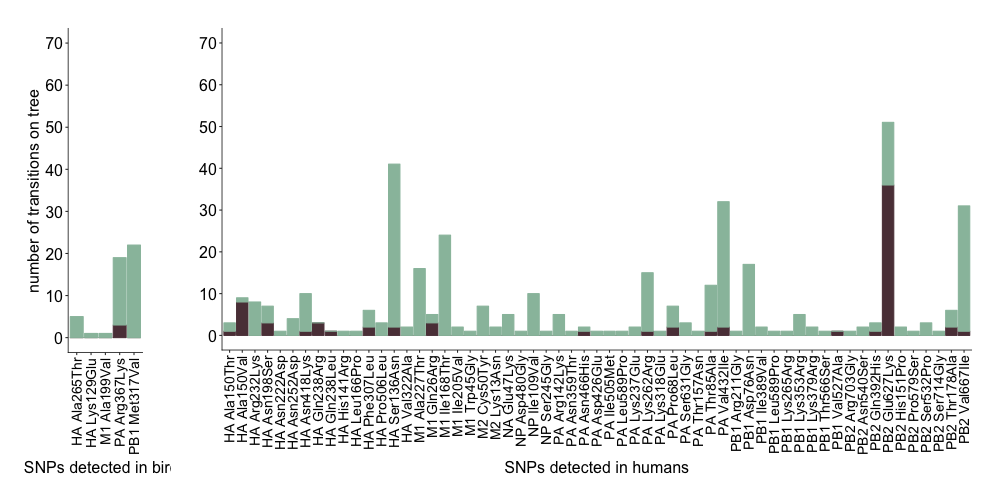

In [36]:
%%R -w 1000 -h 500 -u px -i duck_melted,human_melted  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

left.plot <- ggplot(data=duck_melted, aes(x=site, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "SNPs detected in birds", y="number of transitions on tree")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+ #labels=c("bird to bird", "human/bird to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=seq(0,70,10))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

right.plot <- ggplot(data=human_melted, aes(x=site, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "SNPs detected in humans")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+ #labels=c("bird to bird", "human/bird to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=seq(0,70,10))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_blank())+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- grid.arrange(left.plot, right.plot, ncol=2, widths=c(1,4.85))
ggsave("Figure-7a-tree-transitions-v2-2019-02-04.pdf", p2, width = 24, height = 5, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")


## Try again, this time using just the amino acid, not the mutation 

I'd like to try this using any mutation that ends in the correct mutation. So for example, an Ala10Thr and Gln10Thr would both get counted towards a mutation to Thr at position 10

In [121]:
# subset witin-host data down to just amino acid change 
wh2 = wh.copy()
wh2['coding_region_change'] = wh2['coding_region_change'].str[3:]
wh2['gene'] = wh2['gene'].fillna("NA")
wh2['site'] = wh2['gene'] + " " + wh2['coding_region_change']
wh2.head()

,coding_region_change,originating_species,gene,site
0,265Thr,duck,HA,HA 265Thr
1,117Arg,duck,NP,NP 117Arg
2,367Lys,duck,PA,PA 367Lys
3,317Val,duck,PB1,PB1 317Val
4,199Val,duck,M1,M1 199Val


In [122]:
# subset tree transitions, and add together transitions to the same amino acid
df2 = df.copy()
df2['coding_region_change'] = df2['coding_region_change'].str[3:]
df2['gene'] = df2['gene'].fillna("NA")
df2['site'] = df2['gene'] + " " + df2['coding_region_change']
df2.head()

,coding_region_change,bird_to_bird,bird_to_human,human_to_human,gene,site
0,102Asp,2,0,0,HA,HA 102Asp
1,102Gly,1,0,0,HA,HA 102Gly
2,102Ser,14,0,0,HA,HA 102Ser
3,102Thr,13,0,1,HA,HA 102Thr
4,102Val,28,1,0,HA,HA 102Val


In [123]:
# collapse down rows with the same site and add values in those rows together 
df2 = df2.groupby('site').aggregate('sum')
df2.reset_index(inplace=True)
df2.head()

,site,bird_to_bird,bird_to_human,human_to_human
0,HA 100Asn,10,0,0
1,HA 100Asp,6,0,1
2,HA 100Gly,1,0,0
3,HA 100His,2,0,0
4,HA 100Ile,2,0,0


In [124]:
merged2 = pd.DataFrame(wh2[['coding_region_change','gene','originating_species', 'site']]).merge(df2, how="left", on=['site'])
merged2 = merged2.drop_duplicates()
merged2['gene'] = merged2['gene'].fillna("NA")
merged2 = merged2.fillna(0)
merged2.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human
0,265Thr,HA,duck,HA 265Thr,5.0,0.0,0.0
1,117Arg,NP,duck,NP 117Arg,0.0,0.0,0.0
2,367Lys,PA,duck,PA 367Lys,16.0,2.0,1.0
3,317Val,PB1,duck,PB1 317Val,22.0,0.0,0.0
4,199Val,M1,duck,M1 199Val,1.0,0.0,0.0


In [125]:
len(wh)

134

In [126]:
merged2['end_in_human'] = merged2['bird_to_human'] + merged2['human_to_human']
merged2.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,end_in_human
0,265Thr,HA,duck,HA 265Thr,5.0,0.0,0.0,0.0
1,117Arg,NP,duck,NP 117Arg,0.0,0.0,0.0,0.0
2,367Lys,PA,duck,PA 367Lys,16.0,2.0,1.0,3.0
3,317Val,PB1,duck,PB1 317Val,22.0,0.0,0.0,0.0
4,199Val,M1,duck,M1 199Val,1.0,0.0,0.0,0.0


In [127]:
sloth = merged2[merged2['site'] == 'HA 238Arg']
sloth

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,end_in_human
100,238Arg,HA,human,HA 238Arg,0.0,1.0,2.0,3.0


In [128]:
# split site into gene and location 
merged2[['gene','site2']] = merged2.site.str.split(" ", expand=True)
merged2['site2'] = merged2.site2.str[0:3]
merged2.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,end_in_human,site2
0,265Thr,HA,duck,HA 265Thr,5.0,0.0,0.0,0.0,265
1,117Arg,NP,duck,NP 117Arg,0.0,0.0,0.0,0.0,117
2,367Lys,PA,duck,PA 367Lys,16.0,2.0,1.0,3.0,367
3,317Val,PB1,duck,PB1 317Val,22.0,0.0,0.0,0.0,317
4,199Val,M1,duck,M1 199Val,1.0,0.0,0.0,0.0,199


In [129]:
# sort 
merged2['gene'] = pd.Categorical(merged2['gene'], ['PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP'])
merged2 = merged2.sort_values(by=['originating_species','gene', 'site'])
merged2.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,end_in_human,site2
3,317Val,PB1,duck,PB1 317Val,22.0,0.0,0.0,0.0,317
2,367Lys,PA,duck,PA 367Lys,16.0,2.0,1.0,3.0,367
5,129Glu,HA,duck,HA 129Glu,1.0,0.0,0.0,0.0,129
0,265Thr,HA,duck,HA 265Thr,5.0,0.0,0.0,0.0,265
12,363Ile,HA,duck,HA 363Ile,1.0,0.0,0.0,0.0,363


In [130]:
# get the order that I want these plotted in 
duck_merged2 = merged2[merged2['originating_species'] == "duck"]
human_merged2 = merged2[merged2['originating_species'] == "human"]
duck_order = duck_merged2['site'].tolist()
human_order = human_merged2['site'].tolist()
print(duck_order)
print(human_order)

['PB1 317Val', 'PA 367Lys', 'HA 129Glu', 'HA 265Thr', 'HA 363Ile', 'NP 117Arg', 'NP 170Leu', 'NP 188Ile', 'NP 215Ile', 'NP 403Val', 'NA 58Glu', 'M1 199Val', 'NS1 207Pro', 'NS1 210Ser', 'NEP 55Leu']
['PB2 151Pro', 'PB2 165Val', 'PB2 178Ala', 'PB2 265His', 'PB2 348Tyr', 'PB2 392His', 'PB2 532Pro', 'PB2 540Ser', 'PB2 579Ser', 'PB2 584Ala', 'PB2 616Thr', 'PB2 627Lys', 'PB2 667Ile', 'PB2 66Thr', 'PB2 678Val', 'PB2 701Asp', 'PB2 703Gly', 'PB2 714Gly', 'PB1 144Val', 'PB1 211Gly', 'PB1 215Gly', 'PB1 265Arg', 'PB1 353Arg', 'PB1 353Glu', 'PB1 379Arg', 'PB1 389Val', 'PB1 484Met', 'PB1 527Ala', 'PB1 566Ser', 'PB1 589Pro', 'PB1 71Glu', 'PB1 76Asn', 'PA 142Lys', 'PA 157Asn', 'PA 169Thr', 'PA 237Glu', 'PA 262Arg', 'PA 318Glu', 'PA 359Thr', 'PA 35Ser', 'PA 426Glu', 'PA 432Ile', 'PA 466His', 'PA 505Met', 'PA 589Pro', 'PA 610Gly', 'PA 631Gly', 'PA 659Pro', 'PA 68Leu', 'PA 85Ala', 'HA 136Asn', 'HA 141Arg', 'HA 142Gly', 'HA 150Thr', 'HA 150Val', 'HA 166Pro', 'HA 172Thr', 'HA 173His', 'HA 176Thr', 'HA 197L

In [131]:
# remove the within-host SNPs that weren't found in the tree at all 
in_tree = merged2[(merged2['bird_to_bird'] + merged2['end_in_human']) > 0]
len(in_tree), len(merged2)

(70, 127)

In [132]:
melted2 = in_tree.melt(value_vars=['bird_to_bird','end_in_human'], id_vars=['originating_species','site'])
melted2.head()

,originating_species,site,variable,value
0,duck,PB1 317Val,bird_to_bird,22.0
1,duck,PA 367Lys,bird_to_bird,16.0
2,duck,HA 129Glu,bird_to_bird,1.0
3,duck,HA 265Thr,bird_to_bird,5.0
4,duck,HA 363Ile,bird_to_bird,1.0


In [133]:
human_melted2 = melted2[melted2['originating_species'] == "human"]
duck_melted2 = melted2[melted2['originating_species'] == "duck"]
duck_melted2

,originating_species,site,variable,value
0,duck,PB1 317Val,bird_to_bird,22.0
1,duck,PA 367Lys,bird_to_bird,16.0
2,duck,HA 129Glu,bird_to_bird,1.0
3,duck,HA 265Thr,bird_to_bird,5.0
4,duck,HA 363Ile,bird_to_bird,1.0
5,duck,M1 199Val,bird_to_bird,1.0
70,duck,PB1 317Val,end_in_human,0.0
71,duck,PA 367Lys,end_in_human,3.0
72,duck,HA 129Glu,end_in_human,0.0
73,duck,HA 265Thr,end_in_human,0.0


In [134]:
len(duck_melted2), len(human_melted2)

(12, 128)

In [ ]:
%%R -w 1000 -h 500 -u px -i duck_melted2,human_melted2  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

duck_melted2$sitef = factor(duck_melted2$site, levels=c('PB1 317Val', 'PA 367Lys', 'HA 129Glu', 'HA 265Thr', 'HA 363Ile', 'NP 117Arg', 'NP 170Leu', 'NP 188Ile', 'NP 215Ile', 'NP 403Val', 'NA 58Glu', 'M1 199Val', 'NS1 207Pro', 'NS1 210Ser', 'NEP 55Leu'))
human_melted2$sitef = factor(human_melted2$site, levels=c('PB2 151Pro', 'PB2 165Val', 'PB2 178Ala', 'PB2 265His', 'PB2 348Tyr', 'PB2 392His', 'PB2 532Pro', 'PB2 540Ser', 'PB2 579Ser', 'PB2 584Ala', 'PB2 616Thr', 'PB2 627Lys', 'PB2 667Ile', 'PB2 66Thr', 'PB2 678Val', 'PB2 701Asp', 'PB2 703Gly', 'PB2 714Gly', 'PB1 144Val', 'PB1 211Gly', 'PB1 215Gly', 'PB1 265Arg', 'PB1 353Arg', 'PB1 353Glu', 'PB1 379Arg', 'PB1 389Val', 'PB1 484Met', 'PB1 527Ala', 'PB1 566Ser', 'PB1 589Pro', 'PB1 71Glu', 'PB1 76Asn', 'PA 142Lys', 'PA 157Asn', 'PA 169Thr', 'PA 237Glu', 'PA 262Arg', 'PA 318Glu', 'PA 359Thr', 'PA 35Ser', 'PA 426Glu', 'PA 432Ile', 'PA 466His', 'PA 505Met', 'PA 589Pro', 'PA 610Gly', 'PA 631Gly', 'PA 659Pro', 'PA 68Leu', 'PA 85Ala', 'HA 136Asn', 'HA 141Arg', 'HA 142Gly', 'HA 150Thr', 'HA 150Val', 'HA 166Pro', 'HA 172Thr', 'HA 173His', 'HA 176Thr', 'HA 197Leu', 'HA 198Ser', 'HA 210Thr', 'HA 222Asp', 'HA 226Ala', 'HA 232Gly', 'HA 232Lys', 'HA 238Arg', 'HA 238Leu', 'HA 252Asp', 'HA 307Leu', 'HA 322Ala', 'HA 418Lys', 'HA 503Cys', 'HA 506Leu', 'HA 91Gly', 'NP 108Pro', 'NP 109Val', 'NP 166Val', 'NP 220Gly', 'NP 225Thr', 'NP 245Gly', 'NP 246Gly', 'NP 260Val', 'NP 267Gly', 'NP 480Gly', 'NP 98Gln', 'NP 98Leu', 'NA 106Gln', 'NA 129Asp', 'NA 149Arg', 'NA 214Ile', 'NA 270Ser', 'NA 344Asn', 'NA 344Gly', 'NA 353Val', 'NA 416Thr', 'NA 418Ala', 'NA 47Lys', 'M1 168Thr', 'M1 185Asp', 'M1 205Val', 'M1 227Thr', 'M1 26Arg', 'M1 30Asn', 'M1 45Gly', 'M2 10Arg', 'M2 13Asn', 'M2 50Tyr', 'M2 85Ala', 'NS1 159Leu', 'NEP 24Leu', 'NEP 47Gly'))
                            
left.plot <- ggplot(data=duck_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "SNPs detected in birds", y="number of transitions on tree")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+ #labels=c("bird to bird", "human/bird to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=c(0,10,20,30,40,50,60,70))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

right.plot <- ggplot(data=human_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "SNPs detected in humans")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), labels=c("avian to avian", "human/avian to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=c(0,10,20,30,40,50,60,70))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_blank())+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- grid.arrange(left.plot, right.plot, ncol=2, widths=c(1,5.75))
ggsave("Figure-7c-tree-transitions-2019-03-04.pdf", p2, width = 20, height = 5, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")


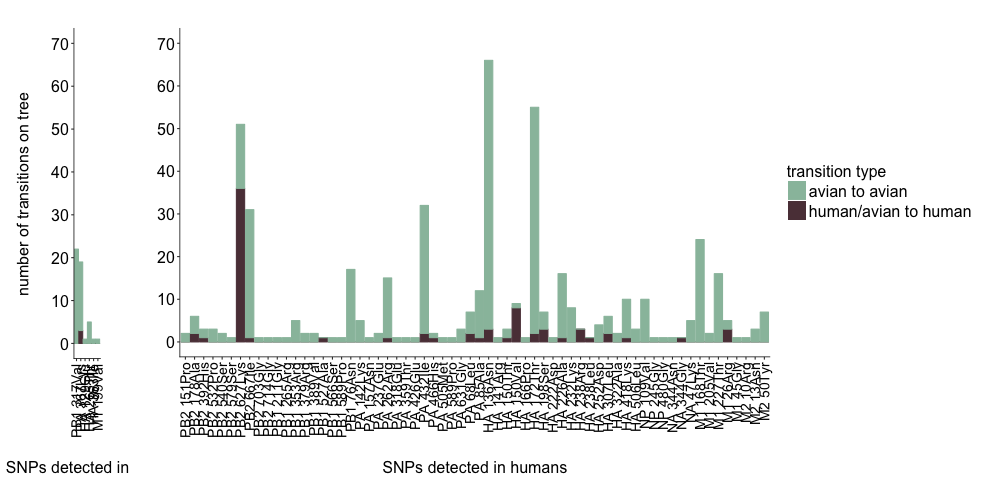

In [144]:
%%R -w 1000 -h 500 -u px -i duck_melted2,human_melted2  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

duck_melted2$sitef = factor(duck_melted2$site, levels=c('PB1 317Val', 'PA 367Lys', 'HA 129Glu', 'HA 265Thr', 'HA 363Ile', 'NP 117Arg', 'NP 170Leu', 'NP 188Ile', 'NP 215Ile', 'NP 403Val', 'NA 58Glu', 'M1 199Val', 'NS1 207Pro', 'NS1 210Ser', 'NEP 55Leu'))
human_melted2$sitef = factor(human_melted2$site, levels=c('PB2 151Pro', 'PB2 165Val', 'PB2 178Ala', 'PB2 265His', 'PB2 348Tyr', 'PB2 392His', 'PB2 532Pro', 'PB2 540Ser', 'PB2 579Ser', 'PB2 584Ala', 'PB2 616Thr', 'PB2 627Lys', 'PB2 667Ile', 'PB2 66Thr', 'PB2 678Val', 'PB2 701Asp', 'PB2 703Gly', 'PB2 714Gly', 'PB1 144Val', 'PB1 211Gly', 'PB1 215Gly', 'PB1 265Arg', 'PB1 353Arg', 'PB1 353Glu', 'PB1 379Arg', 'PB1 389Val', 'PB1 484Met', 'PB1 527Ala', 'PB1 566Ser', 'PB1 589Pro', 'PB1 71Glu', 'PB1 76Asn', 'PA 142Lys', 'PA 157Asn', 'PA 169Thr', 'PA 237Glu', 'PA 262Arg', 'PA 318Glu', 'PA 359Thr', 'PA 35Ser', 'PA 426Glu', 'PA 432Ile', 'PA 466His', 'PA 505Met', 'PA 589Pro', 'PA 610Gly', 'PA 631Gly', 'PA 659Pro', 'PA 68Leu', 'PA 85Ala', 'HA 136Asn', 'HA 141Arg', 'HA 142Gly', 'HA 150Thr', 'HA 150Val', 'HA 166Pro', 'HA 172Thr', 'HA 173His', 'HA 176Thr', 'HA 197Leu', 'HA 198Ser', 'HA 210Thr', 'HA 222Asp', 'HA 226Ala', 'HA 232Gly', 'HA 232Lys', 'HA 238Arg', 'HA 238Leu', 'HA 252Asp', 'HA 307Leu', 'HA 322Ala', 'HA 418Lys', 'HA 503Cys', 'HA 506Leu', 'HA 91Gly', 'NP 108Pro', 'NP 109Val', 'NP 166Val', 'NP 220Gly', 'NP 225Thr', 'NP 245Gly', 'NP 246Gly', 'NP 260Val', 'NP 267Gly', 'NP 480Gly', 'NP 98Gln', 'NP 98Leu', 'NA 106Gln', 'NA 129Asp', 'NA 149Arg', 'NA 214Ile', 'NA 270Ser', 'NA 344Asn', 'NA 344Gly', 'NA 353Val', 'NA 416Thr', 'NA 418Ala', 'NA 47Lys', 'M1 168Thr', 'M1 185Asp', 'M1 205Val', 'M1 227Thr', 'M1 26Arg', 'M1 30Asn', 'M1 45Gly', 'M2 10Arg', 'M2 13Asn', 'M2 50Tyr', 'M2 85Ala', 'NS1 159Leu', 'NEP 24Leu', 'NEP 47Gly'))
                            
left.plot <- ggplot(data=duck_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "\nSNPs detected in birds", y="number of transitions on tree\n")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+ #labels=c("bird to bird", "human/bird to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=c(0,10,20,30,40,50,60,70))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,0.6),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

right.plot <- ggplot(data=human_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "\nSNPs detected in humans")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), labels=c("avian to avian", "human/avian to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=c(0,10,20,30,40,50,60,70))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_blank())+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,0.8,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- grid.arrange(left.plot, right.plot, ncol=2, widths=c(0.85,5.75))
ggsave("Figure-7c-v2-tree-transitions-2019-03-04.pdf", p2, width = 22, height = 5, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")


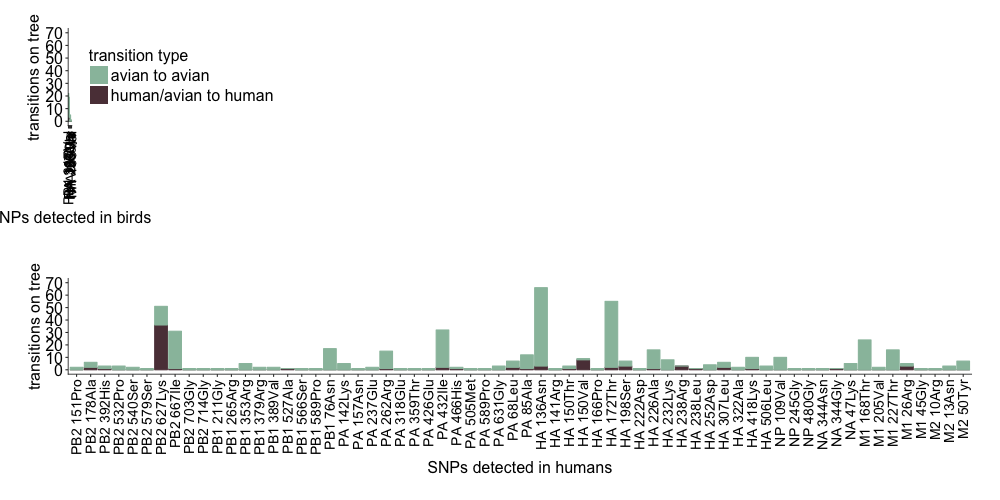

In [145]:
%%R -w 1000 -h 500 -u px -i duck_melted2,human_melted2  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

duck_melted2$sitef = factor(duck_melted2$site, levels=c('PB1 317Val', 'PA 367Lys', 'HA 129Glu', 'HA 265Thr', 'HA 363Ile', 'NP 117Arg', 'NP 170Leu', 'NP 188Ile', 'NP 215Ile', 'NP 403Val', 'NA 58Glu', 'M1 199Val', 'NS1 207Pro', 'NS1 210Ser', 'NEP 55Leu'))
human_melted2$sitef = factor(human_melted2$site, levels=c('PB2 151Pro', 'PB2 165Val', 'PB2 178Ala', 'PB2 265His', 'PB2 348Tyr', 'PB2 392His', 'PB2 532Pro', 'PB2 540Ser', 'PB2 579Ser', 'PB2 584Ala', 'PB2 616Thr', 'PB2 627Lys', 'PB2 667Ile', 'PB2 66Thr', 'PB2 678Val', 'PB2 701Asp', 'PB2 703Gly', 'PB2 714Gly', 'PB1 144Val', 'PB1 211Gly', 'PB1 215Gly', 'PB1 265Arg', 'PB1 353Arg', 'PB1 353Glu', 'PB1 379Arg', 'PB1 389Val', 'PB1 484Met', 'PB1 527Ala', 'PB1 566Ser', 'PB1 589Pro', 'PB1 71Glu', 'PB1 76Asn', 'PA 142Lys', 'PA 157Asn', 'PA 169Thr', 'PA 237Glu', 'PA 262Arg', 'PA 318Glu', 'PA 359Thr', 'PA 35Ser', 'PA 426Glu', 'PA 432Ile', 'PA 466His', 'PA 505Met', 'PA 589Pro', 'PA 610Gly', 'PA 631Gly', 'PA 659Pro', 'PA 68Leu', 'PA 85Ala', 'HA 136Asn', 'HA 141Arg', 'HA 142Gly', 'HA 150Thr', 'HA 150Val', 'HA 166Pro', 'HA 172Thr', 'HA 173His', 'HA 176Thr', 'HA 197Leu', 'HA 198Ser', 'HA 210Thr', 'HA 222Asp', 'HA 226Ala', 'HA 232Gly', 'HA 232Lys', 'HA 238Arg', 'HA 238Leu', 'HA 252Asp', 'HA 307Leu', 'HA 322Ala', 'HA 418Lys', 'HA 503Cys', 'HA 506Leu', 'HA 91Gly', 'NP 108Pro', 'NP 109Val', 'NP 166Val', 'NP 220Gly', 'NP 225Thr', 'NP 245Gly', 'NP 246Gly', 'NP 260Val', 'NP 267Gly', 'NP 480Gly', 'NP 98Gln', 'NP 98Leu', 'NA 106Gln', 'NA 129Asp', 'NA 149Arg', 'NA 214Ile', 'NA 270Ser', 'NA 344Asn', 'NA 344Gly', 'NA 353Val', 'NA 416Thr', 'NA 418Ala', 'NA 47Lys', 'M1 168Thr', 'M1 185Asp', 'M1 205Val', 'M1 227Thr', 'M1 26Arg', 'M1 30Asn', 'M1 45Gly', 'M2 10Arg', 'M2 13Asn', 'M2 50Tyr', 'M2 85Ala', 'NS1 159Leu', 'NEP 24Leu', 'NEP 47Gly'))

left.plot <- ggplot(data=duck_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "SNPs detected in birds", y="transitions on tree")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), labels=c("avian to avian", "human/avian to human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=c(0,10,20,30,40,50,60,70))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

right.plot <- ggplot(data=human_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    labs(x = "SNPs detected in humans", y="transitions on tree")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"), guide=FALSE)+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,70), breaks=c(0,10,20,30,40,50,60,70))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- grid.arrange(left.plot, right.plot, ncol=2, widths=c(2,4.5), layout_matrix = rbind(c(1,NA),c(2,2)))
ggsave("Figure-7d-v2-tree-transitions-2019-03-04.pdf", p2, width = 24, height = 8, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")
